In [20]:
import numpy as np
import math
import pandas as pd

In [23]:
!pip install pingouin

  Using cached pingouin-0.5.5-py3-none-any.whl.metadata (19 kB)
  Using cached pandas_flavor-0.7.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached xarray-2025.6.1-py3-none-any.whl.metadata (12 kB)
Using cached pingouin-0.5.5-py3-none-any.whl (204 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 18.3 MB/s eta 0:00:0000:010:01
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
Using cached pandas_flavor-0.7.0-py3-none-any.whl (8.4 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Using cached xarray-2025.6.1-py3-none-any.whl (1.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [pingouin]4/7 [xarray]learn]


In [24]:
import pingouin as pg
print(pg.__version__)

0.5.5


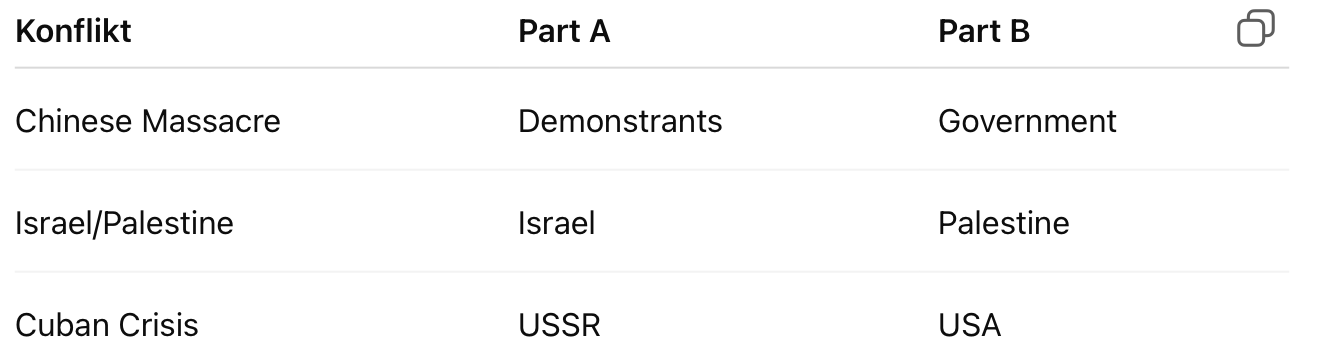

Hvad vi gør:

Vi laver 6 Welch's ANOVA-tests:

For hver konflikt, sammenligner vi de to parter

For hver af de tre modeller (fx ChatGPT, Mistral, DeepSeek)

Med bootstrappede sentiment-middelværdier

Krav til DataFrame (df)

Den skal have mindst følgende kolonner:

"conflict" – fx "Chinese Massacre"

"model" – fx "ChatGPT"

"point_of_view" – fx "Demonstrants", "Government"

"overall_compound" – sentiment score (float)

Hvad kan vi komme til at konkludere?

p-value < 0.05: der er statistisk forskel i hvordan modellen vurderer de to parter i konflikten.

Du kan fx se om en model skildrer en part mere negativt eller positivt end den anden.

In [25]:
import pandas as pd
import pingouin as pg

def bootstrap_samples(df, n_samples=1000):
    return pd.Series([
        df.sample(n=len(df), replace=True)['overall_compound'].mean()
        for _ in range(n_samples)
    ])

# Konflikter og deres to parter (for sikkerhed)
conflict_parties = {
    "Chinese Massacre": ["Demonstrants", "Government"],
    "Israel/Palestine": ["Israel", "Palestine"],
    "Cuban Crisis": ["USSR", "USA"]
}

results = []

# Loop over konflikter
for conflict, parties in conflict_parties.items():
    conflict_df = df[df['conflict'] == conflict]

    # Loop over modeller
    for model in conflict_df['model'].unique():
        model_df = conflict_df[conflict_df['model'] == model]

        # Check at begge parter findes i datasættet
        if not all(p in model_df['point_of_view'].values for p in parties):
            print(f"⚠️ Mangler part i '{conflict}' for model '{model}'. Skipper.")
            continue

        # Bootstrappet samples pr. part
        boot_data = []
        for party in parties:
            party_df = model_df[model_df['point_of_view'] == party]
            boot_means = bootstrap_samples(party_df, n_samples=1000)
            temp_df = pd.DataFrame({
                "boot_mean": boot_means,
                "point_of_view": party
            })
            boot_data.append(temp_df)

        # Kombinér og kør Welch ANOVA
        boot_df = pd.concat(boot_data, ignore_index=True)
        welch = pg.welch_anova(dv='boot_mean', between='point_of_view', data=boot_df)

        results.append({
            "conflict": conflict,
            "model": model,
            "party_A": parties[0],
            "party_B": parties[1],
            "F": welch.loc[0, "F"],
            "p-value": welch.loc[0, "p-unc"]
        })

# Resultater som DataFrame
results_df = pd.DataFrame(results)

# Udskriv
print("\n📊 Welch ANOVA-resultater:")
print(results_df)

KeyError: 'conflict'